# Linear Regression

### 1.0 Importing Packages
* **numpy**: is a fundamental package for scientific computing in Python. It provides efficient data structures (such as arrays) for data manipulation, numerical computations and mathematical operations essential for linear regression modelling.
* **pandas**: is a powerful library for data manipulation and analysis in Python. It can be used to read data from various sources, organise and preprocess data before fitting the model.
* **matplotlib**: is a Python library for creating data visualizations. It can be used to create a variety of visualisation such as scatter plots, line plots and histograms. It is useful for visualising regression line and residuals in linear regression models.
* **seaborn**: is built on top of Matplotlib and provides higher-level statistical visualizations. It can be used to create more complex visualisations such as regression plots and enhance the aesthetics of plots for better insights. 
* **sklearn**: is a machine learning library with tools for various algorithms, including linear regression models. It also offer model evaluation metrics (e.g., R-squared, mean squared error) and provide functions for preprocessing such as (test-train spliting). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

/Users/khantminnaing/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 2.0 Importing Dataset

In [2]:
df1 = pd.read_csv("../data/df_prepared.csv", index_col=0)

In [3]:
df1.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left_binned,duration_sqrt,price
0,-1.368800,-1.732372,0.198274,-2.4911,0.236474,0.37094,-0.674351,2.375914,-1.742522,5953.0
1,-1.368800,-1.732372,-0.298600,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940,5953.0
2,-1.562898,-1.732372,-0.298600,-2.4911,-2.002790,0.37094,-0.674351,2.375914,-1.742522,5956.0
3,0.885018,-1.732372,0.469739,-2.4911,-0.820969,0.37094,-0.674351,2.375914,-1.717006,5955.0
4,0.885018,-1.732372,0.469739,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940,5955.0


### 3.0 Parametric Testing

Before we fit the linear regression model, it is important to conduct paramatric testing, particularly Pearson's correlation and multicollinearity.

### Pearson's Correlation Matrix

A correlation matrix is a common tool used to compare the coefficients of correlation between different features (or attributes) in a dataset. It allows us to visualize how much (or how little) correlation exists between different variables. This is an important step in pre-processing machine learning pipelines. Since the correlation matrix allows us to identify variables that have high degrees of correlation, they allow us to reduce the number of features we may have in a dataset. Pearson’s correlation is a commonly used correlation coefficient to calculate and construct a correlation matrix.

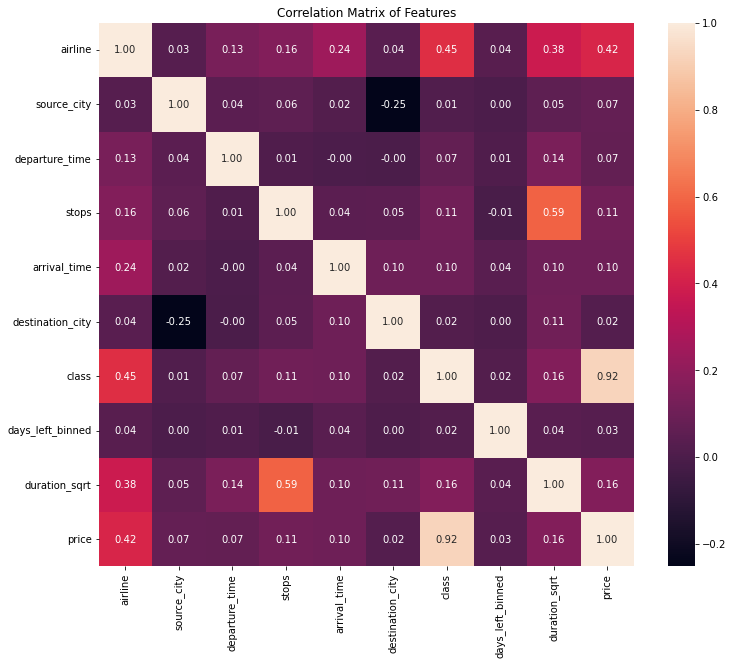

In [4]:
correlation_matrix = df1.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

One way to visualise the p-value associated with each correlation coefficients is to create a `mask` argument to be used with `heatmap()` function. Here, we first create a new function called `corr_sig()` which will calculate the p-values. Then, we filter out the correlation values whose p-value is greater than 0.05 (95% Significance Level) and use these values to create the mask argument. Finally, we create a new correlation matrix specifying the `mask` argument.

Reference: https://copyprogramming.com/howto/seaborn-correlation-matrix-with-p-values-with-python

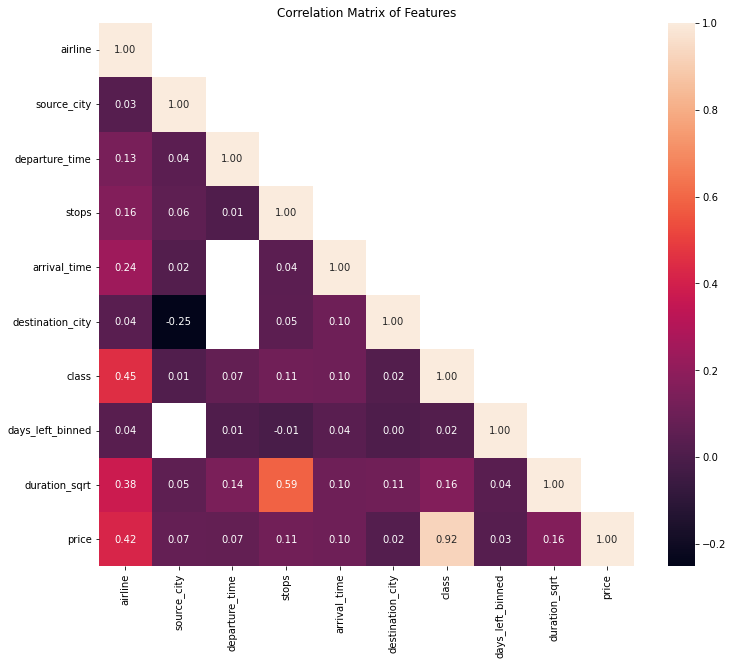

In [5]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

p_values = corr_sig(df1)
mask = np.invert(np.tril(p_values<0.05))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", mask=mask)
plt.title('Correlation Matrix of Features')
plt.show()

Another way to visualise this is to tabulate the p-values. Here we create a new function called `corr_full()` to implement such. 

Reference: https://pub.towardsai.net/building-correlation-matrix-with-p-values-in-python-76ffd3c2365e

In [6]:
 def corr_full(df, numeric_only=True, rows=['corr', 'p-value', 'obs']):
    
    # Calculate Pearson correlation coefficients
    corr_matrix = df.corr(method='pearson')
    
    # Calculate the p-values using scipy's pearsonr
    pvalue_matrix = df.corr( 
        method=lambda x, y: pearsonr(x, y)[1])
    
    # Calculate the non-null observation count for each column
    obs_count = df.apply(lambda x: x.notnull().sum())
    
    # Calculate observation count for each pair of columns
    obs_matrix = pd.DataFrame(
        index=corr_matrix.columns, columns=corr_matrix.columns)
    for col1 in obs_count.index:
        for col2 in obs_count.index:
            obs_matrix.loc[col1, col2] = min(obs_count[col1], obs_count[col2])
        
    # Create a multi-index dataframe to store the formatted correlations
    formatted_table = pd.DataFrame(
        index=pd.MultiIndex.from_product([corr_matrix.columns, rows]), 
        columns=corr_matrix.columns
    )
    
    # Assign values to the appropriate cells in the formatted table
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if 'corr' in rows:
                formatted_table.loc[
                    (col1, 'corr'), col2] = corr_matrix.loc[col1, col2]
            
            if 'p-value' in rows:
                # Avoid p-values for diagonal they correlate perfectly
                if col1 != col2:
                    formatted_table.loc[
                        (col1, 'p-value'), col2] = f"({pvalue_matrix.loc[col1, col2]:.4f})"
            if 'obs' in rows:
                formatted_table.loc[
                    (col1, 'obs'), col2] = obs_matrix.loc[col1, col2]
    
    return(formatted_table.fillna('')
           .style.set_properties(**{'text-align': 'center'}))

In [7]:
correlation_matrix_full = corr_full(df1, rows=['corr', 'p-value'])
correlation_matrix_full

### Multicollinearity

Regression models are sensitive to multicollinearity. Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using various techniques. one such technique is the Variance Inflation Factor(VIF)

Before we calculate the VIF values, we will need to drop the dependent variable. To do so, we will create a new df called X which will only include independent variables

In [8]:
X = df1. drop('price', axis=1)
X.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left_binned,duration_sqrt
0,-1.368800,-1.732372,0.198274,-2.4911,0.236474,0.37094,-0.674351,2.375914,-1.742522
1,-1.368800,-1.732372,-0.298600,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940
2,-1.562898,-1.732372,-0.298600,-2.4911,-2.002790,0.37094,-0.674351,2.375914,-1.742522
3,0.885018,-1.732372,0.469739,-2.4911,-0.820969,0.37094,-0.674351,2.375914,-1.717006
4,0.885018,-1.732372,0.469739,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940


Now that the data is ready, we will compute the VIF values for each feature in our dataset.

In [9]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

            feature       VIF
0           airline  1.499783
1       source_city  1.079051
2    departure_time  1.036798
3             stops  1.558686
4      arrival_time  1.074553
5  destination_city  1.096754
6             class  1.256327
7  days_left_binned  1.004452
8     duration_sqrt  1.799448


There are currently no established criteria for identifying the extent of variance inflation factors that result in poorly estimated coefficients. A frequently used benchmark for VIF in numerous regression studies is VIF ≥ 5. Based on the results above, it appears that none of our features have issue with multicollinearity. 

### 4.0 Multiple Linear Regression Model Fitting

### 4.1 Test Train Split

In [10]:
X = df1. drop('price', axis=1)
y = df1['price']

We will use the rule-of-thumb 80:20 split for train and test datasets respectively. We will use `train_test_split()` function from sklearn to split the dataset.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 4.2 Scatter Plots of Training Data

Linear regression assumes a linear relationship between the independent and dependent variables. If the relationship is non-linear, linear regression will not provide a good fit to the data. Scatter plots can help identify non-linear patterns. To do so, we will create scatter plots for each of the independent variable of our dataset.

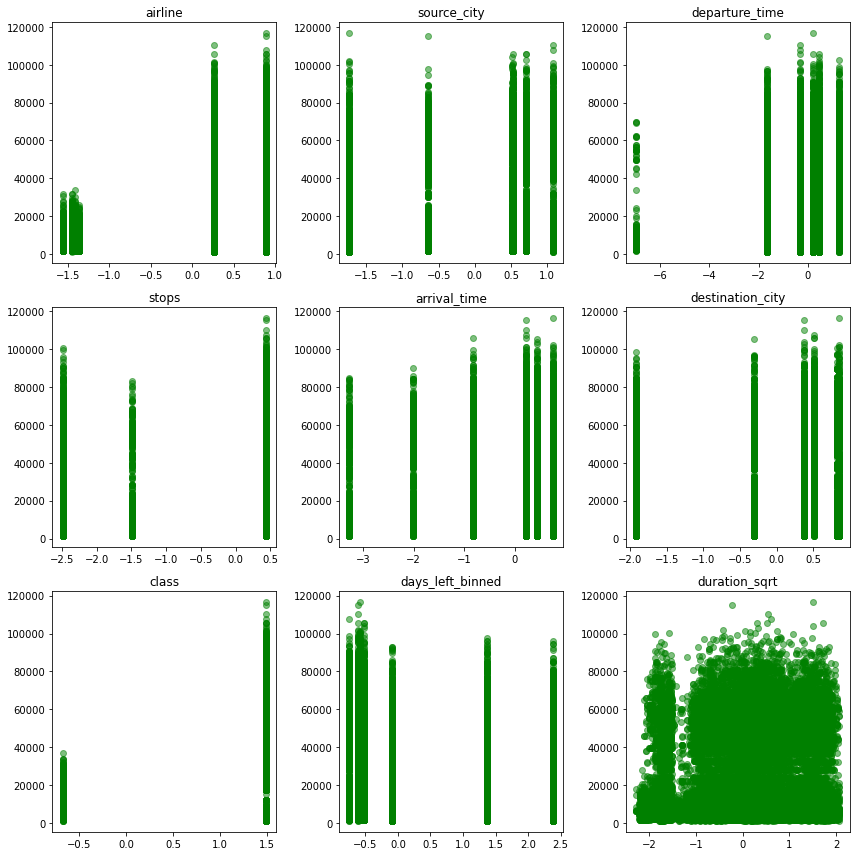

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, col in enumerate(X_train.columns):
    ax = axs[i // 3, i % 3]  # Calculate subplot position
    ax.scatter(X_test[col], y_test, color='g', alpha=0.5)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In our dataset, it is observed that only `duration_sqrt` is a continuous, linear variable while the rest of the variables are of categorical nature. Target encoding is a method used to transform categorical variables based on the mean of the target variable. This can sometimes improve the performance of linear regression models by capturing more information about the category in a way that’s easier for the model to understand.

However, it’s important to note that target encoding can introduce a form of **data leakage** where information from the target variable is used in the creation of the features. This can lead to overly optimistic model performance during training and poorer performance when the model is applied to new data.

Moreover, target encoding does not change the fact that linear regression is designed for continuous dependent variables. Since majority of the dependent variables in our dataset is categorical, even after target encoding, they still exhibit categorical nature (as evident in scatter plots) and linear regression may still not be the best choice.

### Model Fitting

In [13]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

### Intercept and Coefficient Estimates

Let's try to display the **intercept** and **coefficient estimates** from the `mlr` model that we just fitted.

In [14]:
intercept = mlr.intercept_
coefficients = list(zip(X, mlr.coef_))

# Creating a DataFrame to display the results in a tabulated format
results = pd.DataFrame(coefficients, columns=['Variable', 'Coefficient'])
results.loc[len(results.index)] = ['Intercept', intercept] 

print(results)

           Variable   Coefficient
0           airline     30.368525
1       source_city   1402.170352
2    departure_time     54.229854
3             stops     63.047652
4      arrival_time     -9.450533
5  destination_city    491.904466
6             class  20793.443596
7  days_left_binned    274.193101
8     duration_sqrt    175.658959
9         Intercept  20630.077106


### 5.0 Prediction

In [15]:
y_pred = mlr.predict(X_test)

In [16]:
predicted_values = y_pred[1:500]
fitted_values = y_test[1:500]
residuals = predicted_values - fitted_values

Residuals versus fits plots are a common approach to verify the assumption of linear regression that the residuals are randomly distributed and have constant variance. Ideally, the points should fall randomly on both sides of 0, with no recognizable patterns in the points.

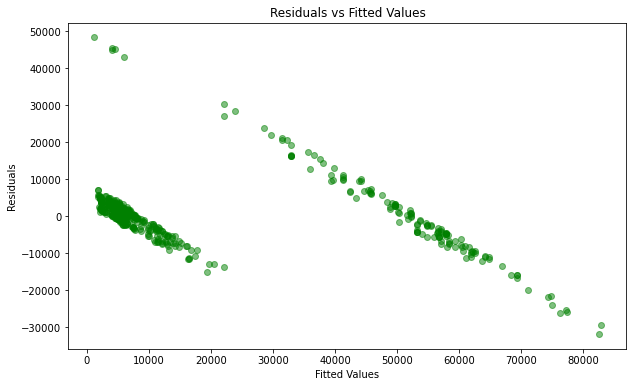

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, color ='g', alpha=0.5)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

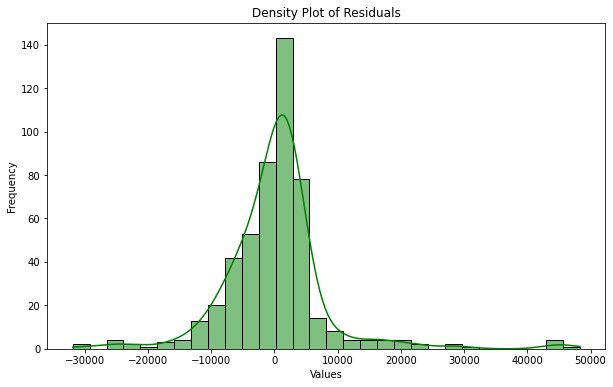

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='green', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Density Plot of Residuals')
 
plt.show()

### 5.1 Shapiro-Wilk Test

The Shapiro-Wilk Test is a statistical test that is used to check if a sample of data follows a normal distribution. In the context of a linear regression model, we often assume that the residuals (the differences between the observed and predicted values) are normally distributed. This assumption is crucial because it underpins the statistical techniques used to construct confidence intervals and hypothesis tests for the coefficients of the model.

Performing a Shapiro-Wilk Test on the residuals of a linear regression model helps us to validate this assumption. If the test indicates that the residuals are not normally distributed, it suggests that our linear model may not be the best fit for the data, and the reliability of the statistical inferences drawn from the model could be compromised. In such cases, we might need to consider other types of models or transformations of the data.

In [19]:
from scipy.stats import shapiro 
from scipy.stats import lognorm

np.random.seed(1)

shapiro(residuals)

ShapiroResult(statistic=0.8222770094871521, pvalue=4.2524102454015917e-23)

In [20]:
np.random.seed(1)

sm.stats.stattools.durbin_watson(residuals)

1.9306856258138905

### 6.0 Evaluation

In [21]:
mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
mean_absolute_percent_error=metrics.mean_absolute_percentage_error(y_test, y_pred) 
mse=metrics.mean_squared_error(y_test, y_pred) 
r2=metrics.r2_score(y_test, y_pred)
adjustedr2 = 1 - (1-r2) * (len(y)-1)/(len(y)-X.shape[1]-1)


metric_resuls = {'Metric': ['R2 Score', 'Adjusted R2 Score', 'Mean Absolute Error','Mean Absolute % Error (MAPE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
        'Value': [str(round(r2, 4)),str(round(adjustedr2, 4)), str(round(mean_absolute_error, 4)), str(round(mean_absolute_percent_error, 4)), str(round(mse, 4)), str(round(np.sqrt(mse), 4))]}

df_metric = pd.DataFrame(metric_resuls)

print(df_metric)

                           Metric         Value
0                        R2 Score        0.8515
1               Adjusted R2 Score        0.8515
2             Mean Absolute Error       5245.99
3    Mean Absolute % Error (MAPE)        0.5696
4        Mean Squared Error (MSE)  75745964.432
5  Root Mean Squared Error (RMSE)     8703.2158


Based on the results of the evaluation metrics, following insights may be inferred.
* The R2 score is 0.8256 and the adjusted R2 score is 0.8256, which means that approximately 82.56% of the variance in the target variable is explained by your model. A high R2 score indicates an adequate model fit.
* The Mean Squared Error (MSE) is 0.1743, which suggests that the overall prediction error is relatively low. 
* The Mean Absolute Error (MAE) is 0.3144 and Root Mean Squared Error (MSE) is 0.4175, indicating somewhat good accuracy in predictions. 

In [22]:
score = metrics.r2_score(y_test, y_pred)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

The accuracy of our model is 85.0%


### 7.0 Ordinary Least Square Regression with Stepwise Removal

In [23]:
ols_m1 = sm.OLS(y_train, X_train).fit()
print(ols_m1.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.470
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                          2.326e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):                        0.00
Time:                        22:29:46   Log-Likelihood:                     -2.7045e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236542   BIC:                                  5.409e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [24]:
new_X = df1. drop(['price','airline'], axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2)

ols_m2 = sm.OLS(new_y_train, new_X_train).fit()
print(ols_m2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.469
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                          2.608e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):                        0.00
Time:                        22:29:47   Log-Likelihood:                     -2.7046e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236543   BIC:                                  5.409e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [25]:
new_X = df1. drop(['price','airline', 'stops'], axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2)

ols_m3 = sm.OLS(new_y_train, new_X_train).fit()
print(ols_m3.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.468
Model:                            OLS   Adj. R-squared (uncentered):              0.468
Method:                 Least Squares   F-statistic:                          2.971e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):                        0.00
Time:                        22:29:48   Log-Likelihood:                     -2.7046e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236544   BIC:                                  5.409e+06
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [26]:
new_X = df1. drop(['price','airline','stops','arrival_time'], axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2)

ols_m4 = sm.OLS(new_y_train, new_X_train).fit()
print(ols_m4.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.468
Model:                            OLS   Adj. R-squared (uncentered):              0.468
Method:                 Least Squares   F-statistic:                          3.470e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):                        0.00
Time:                        22:29:49   Log-Likelihood:                     -2.7046e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236545   BIC:                                  5.409e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [27]:
new_X = df1. drop(['price','airline','stops','arrival_time','departure_time'], axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2)

ols_m5 = sm.OLS(new_y_train, new_X_train).fit()
print(ols_m5.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.470
Model:                            OLS   Adj. R-squared (uncentered):              0.470
Method:                 Least Squares   F-statistic:                          4.190e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):                        0.00
Time:                        22:29:49   Log-Likelihood:                     -2.7046e+06
No. Observations:              236551   AIC:                                  5.409e+06
Df Residuals:                  236546   BIC:                                  5.409e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

All parameters are statistically significant after 5th iteration of stepwise selection. However, adjusted R-squared value after stepwise regression **did not improve** significantly.

There is a possible **negative autocorrelation** in the error terms, provided by 0.295 value of Durbin-Watson statistic. The presence of correlation in error terms drastically reduces model’s accuracy. If the error terms are correlated, the estimated standard errors tend to underestimate the true standard error.

## 8.0 2nd Run of Multiple Linear Regression with Stepwise Regression Parameters

In [28]:
mlr2 = LinearRegression()
mlr2.fit(new_X_train, new_y_train)

intercept = mlr2.intercept_
coefficients = list(zip(new_X, mlr2.coef_))

# Creating a DataFrame to display the results in a tabulated format
results = pd.DataFrame(coefficients, columns=['Variable', 'Coefficient'])
results.loc[len(results.index)] = ['Intercept', intercept] 

print(results)

           Variable   Coefficient
0       source_city   1437.048261
1  destination_city    505.202379
2             class  20782.767618
3  days_left_binned    260.786028
4     duration_sqrt    225.849660
5         Intercept  20622.739741


In [29]:
mlr2_y_pred = mlr2.predict(new_X_test)

In [31]:
mlr2_mean_absolute_error = metrics.mean_absolute_error(new_y_test, mlr2_y_pred)
mlr2_mean_absolute_percent_error=metrics.mean_absolute_percentage_error(new_y_test, mlr2_y_pred) 
mlr2_mse=metrics.mean_squared_error(new_y_test, mlr2_y_pred) 
mlr2_r2=metrics.r2_score(new_y_test, mlr2_y_pred)
mlr2_adjustedr2 = 1 - (1-mlr2_r2) * (len(y)-1)/(len(y)-new_X.shape[1]-1)


mlr2_metric_resuls = {'Metric': ['R2 Score', 'Adjusted R2 Score', 'Mean Absolute Error','Mean Absolute % Error (MAPE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
        'Value': [str(round(mlr2_r2, 4)),str(round(mlr2_adjustedr2, 4)), str(round(mlr2_mean_absolute_error, 4)), str(round(mlr2_mean_absolute_percent_error, 4)), str(round(mlr2_mse, 4)), str(round(np.sqrt(mlr2_mse), 4))]}

mlr2_df_metric = pd.DataFrame(mlr2_metric_resuls)

print(mlr2_df_metric)

                           Metric         Value
0                        R2 Score        0.8568
1               Adjusted R2 Score        0.8568
2             Mean Absolute Error     5187.2062
3    Mean Absolute % Error (MAPE)        0.5544
4        Mean Squared Error (MSE)  72856113.837
5  Root Mean Squared Error (RMSE)     8535.5793


Compare these results to previous model,

In [32]:
print(df_metric)

                           Metric         Value
0                        R2 Score        0.8515
1               Adjusted R2 Score        0.8515
2             Mean Absolute Error       5245.99
3    Mean Absolute % Error (MAPE)        0.5696
4        Mean Squared Error (MSE)  75745964.432
5  Root Mean Squared Error (RMSE)     8703.2158


## 9.0 Regularization: Ridge Regression

In this section, we will try to apply ridge regression and see if the performance improves.

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295689 entries, 0 to 297920
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           295689 non-null  float64
 1   source_city       295689 non-null  float64
 2   departure_time    295689 non-null  float64
 3   stops             295689 non-null  float64
 4   arrival_time      295689 non-null  float64
 5   destination_city  295689 non-null  float64
 6   class             295689 non-null  float64
 7   days_left_binned  295689 non-null  float64
 8   duration_sqrt     295689 non-null  float64
dtypes: float64(9)
memory usage: 22.6 MB


In [35]:
from sklearn.linear_model import Ridge

n_features = 9
n_alpha = 200

beta=np.zeros((n_features,n_alpha))
score=np.zeros((n_alpha, 1))

for alpha in range(n_alpha):
    ridge = Ridge(alpha=alpha) # trying out different values of alpha
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    #score[alpha] = mean_squared_error(y_test, y_pred)
    for i in range(9):
        beta[i][alpha] = ridge.coef_[i]

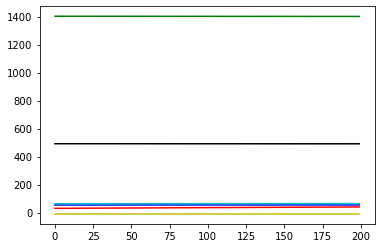

In [36]:
i = 0
plt.plot(beta[i+0], 'r', beta[i+1], 'g', beta[i+2], 'b', beta[i+3], 'c', beta[i+4], 'y', beta[i+5], 'k')
plt.show()

In [37]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

# Create a Ridge regressor object
ridge = Ridge()

# Create the grid search object
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [38]:
# Get the best parameters
print("Best parameters: ", grid.best_params_)

Best parameters:  {'alpha': 0.001}


In the code chunk above, grid.best_params_ is a dictionary that contains the best hyperparameters found by GridSearchCV. We extract the best alpha value, which is the regularization strength for Ridge Regression, and use it to create a new Ridge object. Then, we fit this new model to the data.

Now, we will create a new Ridge regressor with the best parameters

In [39]:
ridge_best = Ridge(alpha=0.001)

# Fit the model to the data
ridge_best.fit(X_train, y_train)

Ridge(alpha=0.001)

In [40]:
 ridge_y_pred = ridge_best.predict(X_test)

In [41]:
ridge_mean_absolute_error = metrics.mean_absolute_error(y_test, ridge_y_pred)
ridge_mean_absolute_percent_error=metrics.mean_absolute_percentage_error(y_test, ridge_y_pred) 
ridge_mse=metrics.mean_squared_error(y_test, ridge_y_pred) 
ridge_r2=metrics.r2_score(y_test, ridge_y_pred)
ridge_adjustedr2 = 1 - (1-ridge_r2) * (len(y)-1)/(len(y)-new_X.shape[1]-1)


ridge_metric_resuls = {'Metric': ['R2 Score', 'Adjusted R2 Score', 'Mean Absolute Error','Mean Absolute % Error (MAPE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
        'Value': [str(round(ridge_r2, 4)),str(round(ridge_adjustedr2, 4)), str(round(ridge_mean_absolute_error, 4)), str(round(ridge_mean_absolute_percent_error, 4)), str(round(ridge_mse, 4)), str(round(np.sqrt(ridge_mse), 4))]}

ridge_df_metric = pd.DataFrame(ridge_metric_resuls)

print(ridge_df_metric)

                           Metric        Value
0                        R2 Score       0.8515
1               Adjusted R2 Score       0.8515
2             Mean Absolute Error      5245.99
3    Mean Absolute % Error (MAPE)       0.5696
4        Mean Squared Error (MSE)  75745964.42
5  Root Mean Squared Error (RMSE)    8703.2158


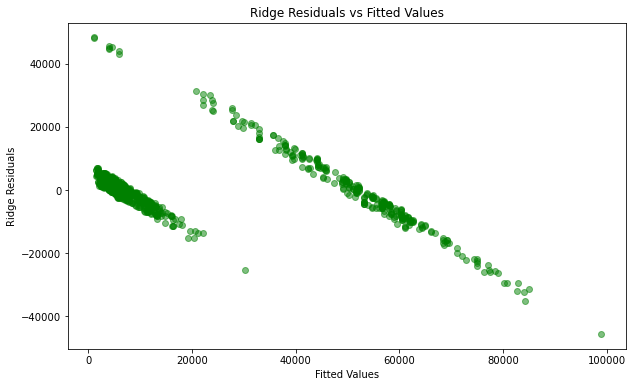

In [42]:
ridge_predicted_values = ridge_y_pred[1:1000]
fitted_values = y_test[1:1000]
ridge_residuals = ridge_predicted_values - fitted_values

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, ridge_residuals, color ='g', alpha=0.5)
plt.title('Ridge Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Ridge Residuals')
plt.show()

From the plot, it is clear that there’s a noticeable pattern where residuals are mostly positive at lower actual values and become increasingly negative as actual values rise. This indicates potential issues with the model fit or heteroscedasticity.

In a well-specified model, the residuals should be randomly scattered around zero across all levels of the explanatory variable. However, in this case, as the actual values increase, the residuals become more negative. This indicates that the model is not capturing some underlying pattern in the data.

**Issue:** There is clear autocorrelation between the residual (error) terms, violating normality assumption.

## 10.0 Log Transformation of Price

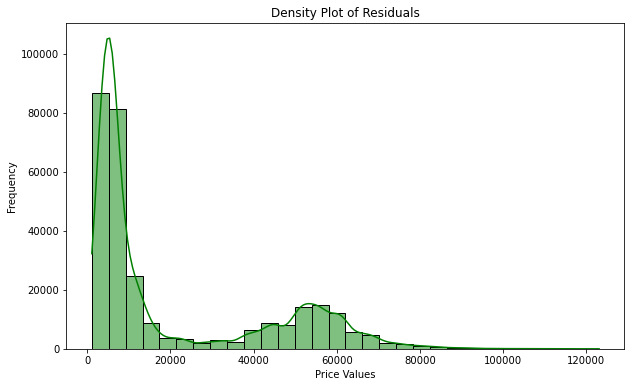

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(df1['price'], bins=30, kde=True, color='green', edgecolor='black')
plt.xlabel('Price Values')
plt.ylabel('Frequency')
plt.title('Density Plot of Residuals')
 
plt.show()

In [44]:
df1['log_price'] = np.log(df1['price'])

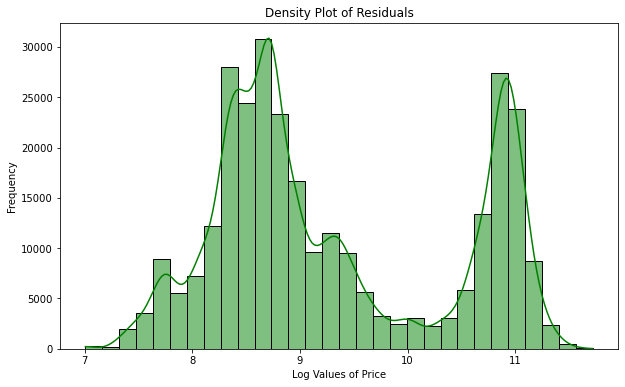

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(df1['log_price'], bins=30, kde=True, color='green', edgecolor='black')
plt.xlabel('Log Values of Price')
plt.ylabel('Frequency')
plt.title('Density Plot of Residuals')
 
plt.show()

### 11.0 3rd Run of Multiple Linear Regression Model with Log Transformation of Price


In [46]:
X = df1. drop(['price','log_price'], axis=1)
y = df1['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
mlr3 = LinearRegression()
mlr3.fit(X_train, y_train)
mlr3_y_pred = mlr3.predict(X_test)

In [ ]:
y_test = np.exp(y_test)
mlr3_y_pred = np.exp(mlr3_y_pred)

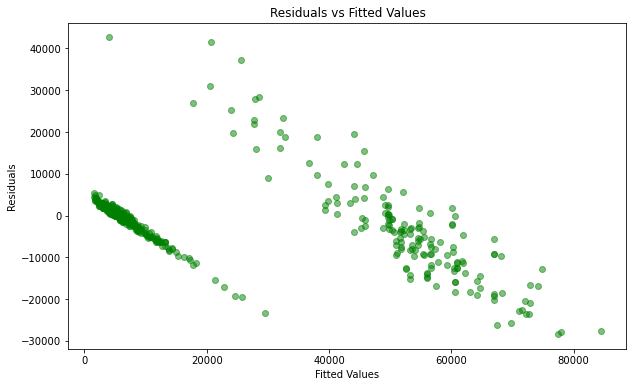

In [59]:
predicted_values = mlr3_y_pred[1:500]
fitted_values = y_test[1:500]
residuals = predicted_values - fitted_values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, color ='g', alpha=0.5)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

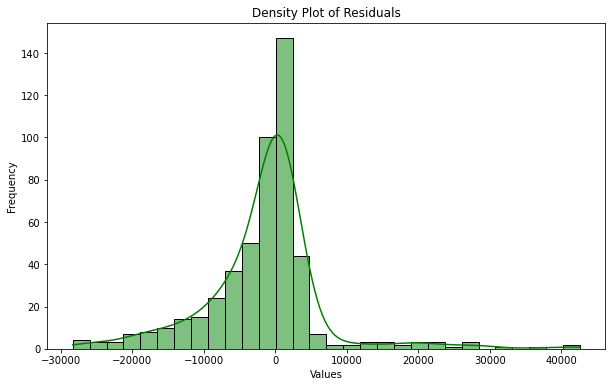

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='green', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Density Plot of Residuals')
 
plt.show()

In [61]:
mlr3_mean_absolute_error = metrics.mean_absolute_error(y_test, mlr3_y_pred)
mlr3_mean_absolute_percent_error=metrics.mean_absolute_percentage_error(y_test, mlr3_y_pred) 
mlr3_mse=metrics.mean_squared_error(y_test, mlr3_y_pred) 
mlr3_r2=metrics.r2_score(y_test, mlr3_y_pred)
mlr3_adjustedr2 = 1 - (1-mlr3_r2) * (len(y)-1)/(len(y)-X.shape[1]-1)


mlr3_metric_results = {'Metric': ['R2 Score', 'Adjusted R2 Score', 'Mean Absolute Error','Mean Absolute % Error (MAPE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
        'Value': [str(round(mlr3_r2, 4)),str(round(mlr3_adjustedr2, 4)), str(round(mlr3_mean_absolute_error, 4)), str(round(mlr3_mean_absolute_percent_error, 4)), str(round(mlr3_mse, 4)), str(round(np.sqrt(mlr3_mse), 4))]}

mlr3_df_metric = pd.DataFrame(mlr3_metric_results)

print(mlr3_df_metric)

                           Metric          Value
0                        R2 Score         0.8374
1               Adjusted R2 Score         0.8374
2             Mean Absolute Error       5412.467
3    Mean Absolute % Error (MAPE)         0.4686
4        Mean Squared Error (MSE)  83031802.8929
5  Root Mean Squared Error (RMSE)      9112.1788


Comparing this result from previous two models

In [50]:
#MLR Model 1
print(df_metric)

                           Metric         Value
0                        R2 Score        0.8515
1               Adjusted R2 Score        0.8515
2             Mean Absolute Error       5245.99
3    Mean Absolute % Error (MAPE)        0.5696
4        Mean Squared Error (MSE)  75745964.432
5  Root Mean Squared Error (RMSE)     8703.2158


In [51]:
#MLR Model 2
print(mlr2_df_metric)

                           Metric         Value
0                        R2 Score        0.8568
1               Adjusted R2 Score        0.8568
2             Mean Absolute Error     5187.2062
3    Mean Absolute % Error (MAPE)        0.5544
4        Mean Squared Error (MSE)  72856113.837
5  Root Mean Squared Error (RMSE)     8535.5793


In [52]:
#Ridge Model
print(ridge_df_metric)

                           Metric        Value
0                        R2 Score       0.8515
1               Adjusted R2 Score       0.8515
2             Mean Absolute Error      5245.99
3    Mean Absolute % Error (MAPE)       0.5696
4        Mean Squared Error (MSE)  75745964.42
5  Root Mean Squared Error (RMSE)    8703.2158


From these outputs, log transformation of price helps in reduce the mean absolute percent error but overall adjusted R2 and RMSE values increase (did not improve)